<a href="https://colab.research.google.com/github/mgorsk1/gargabe-detector-app/blob/baseline/model/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Link to the data: https://drive.google.com/open?id=1m6-StcbywxvW95NsyibE7tl3PYRdlfcx

copy data to your google drive and modify `project_dir`. 

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
project_dir = 'My Drive/projects/ING/Experiment_week/garbage_segmentation/'
data_dir = project_dir + 'data/'

In [93]:
classes = os.listdir(data_dir)
classes

['metal', 'paper', 'glass', 'plastic']

In [0]:
def stack_images_and_labels(do_save=True):
    file_paths = glob.glob(project_dir + '*/*')

    df_files = pd.DataFrame(file_paths, columns=['file_path'])
    df_files = df_files.assign(label=df_files['file_path'].str.split('/').apply(lambda x: x[-2]))

    images_list, labels_list = [], []
    for _, row in tqdm(df_files.iterrows(), total=len(df_files)):
        file_path = row[0]
        label = row[1]

        image = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)

        images_list.append(image)
        labels_list.append(label)

    images = np.stack(images_list)
    labels = np.stack(labels_list)

    if do_save:
        np.save(images, project_dir + 'images.npy')
        np.save(labels, project_dir + 'labels.npy')

    return images, labels

In [0]:
images, labels = stack_images_and_labels()

In [7]:
images = np.load(project_dir + 'images.npy')
labels = np.load(project_dir + 'labels.npy')

images.shape, labels.shape

((3586, 224, 224, 3), (3586,))

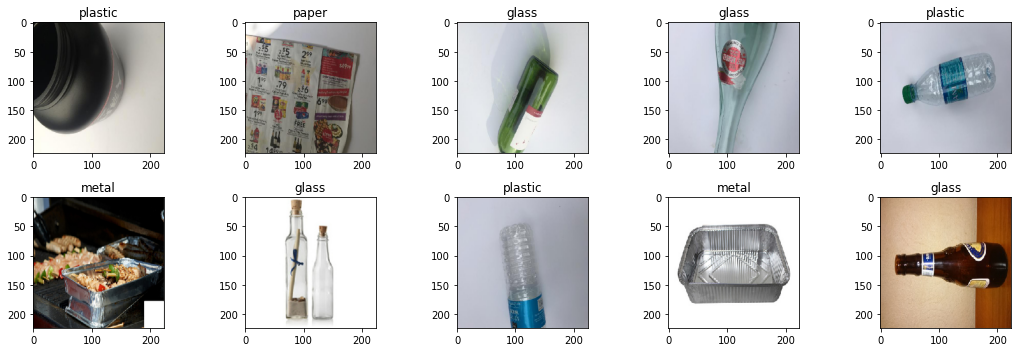

In [23]:
indices = np.random.choice(range(len(images)), size=10)
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
axs = [j for i in axs for j in i]
for i, index in enumerate(indices):
    axs[i].imshow(images[index].astype(int)) 
    axs[i].set_title(labels[index])

plt.tight_layout()

In [0]:
def compute_image_embedding(images, Model, preprocess_input, input_shape, do_save=True):
    images_preped = preprocess_input(np.copy(images))
    model = Model(include_top=False, input_shape=input_shape)
    images_embedding = model.predict(images_preped, batch_size=32, verbose=1)
    if do_save:
        np.save(project_dir + 'images_embedding.npy', images_embedding)
    return images_embedding

In [26]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
Model = tf.keras.applications.resnet50.ResNet50
input_shape = (224, 224, 3)

images_embedding = compute_image_embedding(images, Model, preprocess_input, input_shape)

113/113 [==============================] - 7s 61ms/step


In [0]:
images_embedding = np.load(project_dir + 'images_embedding.npy')
labels = np.load(project_dir + 'labels.npy')

In [34]:
images_embedding.min(), images_embedding.mean(), images_embedding.max(), images_embedding.std()

(0.0, 0.4422787, 136.85416, 1.6771308)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [36]:
images_embedding_train, images_embedding_test, labels_train, labels_test = train_test_split(images_embedding, labels, random_state=1)
images_embedding_train.shape

(2689, 7, 7, 2048)

In [0]:
def to_categorical(labels, label_to_index):
    labels_int = pd.Series(labels).map(label_to_index)
    return tf.keras.utils.to_categorical(labels_int, num_classes=len(label_to_index)) 

In [0]:
label_to_index = dict(zip(classes, range(len(classes))))

labels_train_c = to_categorical(labels_train, label_to_index)
labels_test_c = to_categorical(labels_test, label_to_index)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

In [85]:
new_learning_rate = 0.0001

print('current_learning_rate', tf.keras.backend.get_value(model.optimizer.lr))
tf.keras.backend.set_value(model.optimizer.lr, new_learning_rate)
print('current_learning_rate', tf.keras.backend.get_value(model.optimizer.lr))

current_learning_rate 0.001
current_learning_rate 1e-04


In [86]:
model.fit(images_embedding_train, labels_train_c, batch_size=32, epochs=100)

Epoch 1/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0454
Epoch 2/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0313
Epoch 3/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0290
Epoch 4/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0192
Epoch 5/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0163
Epoch 6/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0149
Epoch 7/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0233
Epoch 8/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0050
Epoch 9/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0070
Epoch 10/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0047
Epoch 11/100
85/85 [==============================] - 2s 18ms/step - loss: 0.1221
Epoch 12/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0212
Epoch 13/100
85/85 [=====

In [89]:
prediction_test = model.predict(images_embedding_test)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.91      0.90      0.90       221
       paper       0.97      0.94      0.96       229
       glass       0.88      0.90      0.89       236
     plastic       0.86      0.89      0.87       211

    accuracy                           0.91       897
   macro avg       0.91      0.91      0.91       897
weighted avg       0.91      0.91      0.91       897



In [90]:
prediction_train = model.predict(images_embedding_train)

print(
    classification_report(
        labels_train_c.argmax(axis=1), 
        prediction_train.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       1.00      1.00      1.00       625
       paper       1.00      1.00      1.00       624
       glass       1.00      1.00      1.00       717
     plastic       1.00      1.00      1.00       723

    accuracy                           1.00      2689
   macro avg       1.00      1.00      1.00      2689
weighted avg       1.00      1.00      1.00      2689

